# Metadata Lookup

Minimal Working Example. Contact: Matthias Zeeman


### History
2023-01-04 
- [x] Python code updated, hybrid of SQL and pandas dataframe

2024-02-05 
- [x] MWE as a standalone Notebook (forked, no dependencies on `urbisphere-dm`). The code is intended for urbisphere workstations (JupyterLab or others), as the variable `apiKeyFile` refers to credentials () that are only available on systems that host replicas of the metadata DBs. 
- [x] Export shape files
- [x] Export feather files (for re-use in R via the `arrow` package)

2025-08-29
- [x] Updates in response to module deprecation warnings.

In [1]:
import json
import os
import sys
from functools import reduce
from pathlib import Path

import pandas as pd
import sqlalchemy as sql

try:
    import MySQLdb
except ImportError:
    import pymysql

    pymysql.install_as_MySQLdb()

In [2]:
import os

import fiona

fiona.drvsupport.supported_drivers[
    "kml"
] = "rw"  # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers[
    "KML"
] = "rw"  # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers[
    "LIBKML"
] = "rw"  # enable KML support which is disabled by default

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
import pandas as pd
import plotly.express as px

# Definitions (Metadata DB)

In [3]:
def metadb_sql_query(date_range=None):
    """SQL queries"""

    def query_sql_stations(date_range=None):
        query_list = ["SELECT * FROM `sdt`"]
        query_list.append("LEFT JOIN `ydt` on `sdt`.`y_id` = `ydt`.`y_id`")

        where_list = []
        if date_range:
            where_list = [
                "( ( `s_end_date` > {date_range_start} OR `s_end_date` IS NULL ) AND ( `s_start_date` < {date_range_end} OR `s_end_date` IS NULL ) )"
            ]

        return (query_list, where_list)

    def query_sql_timeseries(date_range=None):
        # t_id, s_id, p_id, c_id
        query_list = ["SELECT * FROM `tdt`"]

        where_list = []

        return (query_list, where_list)

    def query_sql_instruments(prefix=""):
        # prefix was added to avoid dupl error
        query_list = ["SELECT * FROM `idt`"]
        query_list.append(
            "LEFT JOIN `xdt` as `{0}xdt` on `idt`.`x_id` = `{0}xdt`.`x_id`".format(
                prefix
            )
        )
        query_list.append(
            "LEFT JOIN `odt` as `{0}odt` on `idt`.`o_id` = `{0}odt`.`o_id`".format(
                prefix
            )
        )

        where_list = []

        return (query_list, where_list)

    def query_sql_systems_deployments(date_range=None):
        # parent (a.k.a. "logger") == systems
        q1, w1 = query_sql_instruments(prefix="m_")

        query_list = ["SELECT * FROM ddt"]
        query_list.append("LEFT JOIN `cdt` on `ddt`.`c_id` = `cdt`.`c_id`")
        query_list.append("LEFT JOIN `mdt` on `ddt`.`m_id` = `mdt`.`m_id`")
        query_list.append("LEFT JOIN (")
        query_list.extend(q1[0:1])  # avoid duplicate columns
        query_list.append(") as `m_idt` on `mdt`.`i_id` = `m_idt`.`i_id`")
        query_list.extend([q.replace("`idt`", "`m_idt`") for q in q1[1:]])

        where_list = []
        if date_range:
            where_list = [
                "( `d_end_date` > {date_range_start} AND `d_start_date` < {date_range_end} )"
            ]
            # Or, less strict: "( ( `d_end_date` > {date_range_start} OR `d_end_date` IS NULL ) AND ( `d_start_date` < {date_range_end} OR `d_end_date` IS NULL ) )"

        return (query_list, where_list)

    def query_sql_sensors_deployments(date_range=None):
        # child (a.k.a. "instrument") == sensors
        q1, w1 = query_sql_instruments(prefix="i_")

        query_list = ["SELECT * FROM ddt"]
        query_list.append("LEFT JOIN `cdt` on `ddt`.`c_id` = `cdt`.`c_id`")
        query_list.append("LEFT JOIN (")
        query_list.extend(q1[0:1])  # avoid duplicate columns
        query_list.append(") as `i_idt` on `ddt`.`i_id` = `i_idt`.`i_id`")
        query_list.extend([q.replace("`idt`", "`i_idt`") for q in q1[1:]])

        where_list = []
        if date_range:
            where_list = [
                "( `m_end_date` > {date_range_start} AND `m_start_date` < {date_range_end} )"
            ]
            # Or, less strict: "( ( `m_end_date` > {date_range_start} OR `m_end_date` IS NULL ) AND ( `m_start_date` < {date_range_end} OR `m_end_date` IS NULL ) )"

        return (query_list, where_list)

    def query_sql_timeseries(date_range=None):
        query_list = ["SELECT * FROM tdt"]

        where_list = []

        return (query_list, where_list)

    def query_sql_deployments(date_range):
        q1, w1 = query_sql_systems_deployments(date_range=date_range)
        q2, w2 = query_sql_sensors_deployments(date_range=date_range)
        q3, w3 = query_sql_stations(date_range=date_range)

        q2 = q2[2:]
        q3[0] = "LEFT JOIN `sdt` on `cdt`.`s_id` = `sdt`.`s_id`"

        query_list = q1 + q2 + q3
        where_list = w1 + w2 + w3

        return (query_list, where_list)

    query_list, where_list = query_sql_deployments(date_range)

    query = "\n".join(query_list)
    query += (
        "\nWHERE " + (" AND ".join(where_list)).format(**date_range)
        if where_list
        else ""
    )

    return (query, query_list, where_list)


def metadb_sql_response(query):
    """SQL response handler"""

    def connection_engine():
        # Connection Settings
        apiKeyFile = "/etc/creds/other/.metadb_keys.json"

        with open(apiKeyFile, "r") as keyfile:
            apiKeys = json.load(keyfile)

        apiConf = {
            **dict(database="metadb_deployments"),  # Endpoint of the API
            **apiKeys,
        }

        apiEngine = "mysql://{user}:{passwd}@{host}/{database}".format(**apiConf)
        sqlEngine = sql.create_engine(apiEngine)

        return sqlEngine

    def engine_execute(sql, engine):
        import sqlalchemy
        from sqlalchemy import text

        sqlalchemy_version = sqlalchemy.__version__

        if sqlalchemy_version.startswith("1.4."):
            with engine.connect() as conn:
                return conn.execute(text(sql))
        else:
            # otherwise do it the new way with transactions:
            with engine.connect() as conn:
                result = conn.execute(text(sql))
                conn.commit()
            return(result)

    if isinstance(query, list):
        responses = [metadb_sql_response(q) for q in query]
        dd = pd.concat(responses, axis=1)
    else:
        sqlEngine = connection_engine()

        # sqlalchemy >=2.0 or 1.4
        result = engine_execute(query, sqlEngine)

        dd = pd.DataFrame(result)

    return dd


def metadb_query(
    subset={},  # {"system": {"i_description": ["Doppler LiDAR", "Doppler Lidar"]}}
    debug=False,
):
    """Query handler"""

    def restructure(df):
        keys = list(df.keys())
        # Warning: hardcoded groups of variables, identified by integer column index `(start,end)`.
        # print(list(enumerate(list(df.keys()))))
        key_groups = {
            "station": (72, 96),
            "system": (26, 52),
            "sensor": (52, 72),
            "configuration": (0, 26),
        }

        # deduplicate keys (future: prevent duplication by modified sql queries)
        nkeys = [(k, (keys[n], n)) for k, v in key_groups.items() for n in range(*v)]
        nidx = []
        nid = []
        for i in nkeys:
            n = (i[0], i[1][0])
            k = i[1][1]
            if n not in nidx:
                nidx.append(n)
                nid.append(k)

        df = df.iloc[:, nid]
        df.columns = pd.MultiIndex.from_tuples(nidx)
        return df

    def summary(
        df,
        lut={
            "station_lat": ("station", "s_lat"),
            "station_lon": ("station", "s_lon"),
            "station_height": ("station", "s_height"),
            "station_name": ("station", "s_name"),
            "system_id": ("system", "i_serial"),
            "system_name": ("system", "i_model"),
            "sensor_id": ("sensor", "i_serial"),
            "sensor_name": ("sensor", "i_model"),
        },
    ):
        # computed columns
        lut_df = [
            df.loc[:, ("station")]
            .loc[:, ["y_code", "s_code"]]
            .apply(lambda x: "{}{}".format(x[0], x[1]), axis=1)
            .to_frame(name=("id", "station_id"))
        ]

        # add lookup columns
        lut_df.extend([df.loc[:, v].to_frame(name=("id", k)) for k, v in lut.items()])

        # concatenate
        lut_df = pd.concat(lut_df, axis=1)

        return lut_df

    def filter_subset(ds, subset):
        boo = []
        for k1, d in subset.items():
            for k2, v in d.items():
                key = (k1, k2)
                val = v if isinstance(v, list) else [v]
                if key in ds:
                    boo.append(ds.loc[:, (k1, k2)].isin(val))
        if boo:
            return pd.concat(boo, axis=1)
        else:
            return ds.iloc[:, [0]].astype(bool)

    def filter_values(ds):
        keys = ds.dtypes[ds.dtypes == "object"].keys()
        for k in keys:
            try:
                ds[k] = ds[k].apply(lambda x: x.strip())
            except:
                pass
        return ds

    # lookup by time.
    stime = subset["time"] if "time" in subset else {}
    date_range = {
        "date_range_start": "'{}'".format(stime["start"])
        if "start" in stime
        else "'1970-01-01'",
        "date_range_end": "'{}'".format(stime["end"])
        if "end" in stime
        else "'2099-01-01'",
    }

    # query
    q, ql, wl = metadb_sql_query(date_range)
    if debug:
        print(q)

    # response
    df = metadb_sql_response([q])

    # response filters
    ds = restructure(df)
    ds = pd.concat([summary(ds), ds], axis=1)
    ds = filter_values(ds)
    ss = filter_subset(ds, subset)

    if debug:
        return (ds, ss)
    else:
        return ds.loc[ss.all(axis=1)]

In [4]:
def metadb_query(
    subset={},  # {"system": {"i_description": ["Doppler LiDAR", "Doppler Lidar"]}}
    debug=False,
):
    def restructure(df):
        keys = list(df.keys())
        # Warning: hardcoded groups of variables, identified by integer column index `(start,end)`.
        # print(list(enumerate(list(df.keys()))))
        key_groups = {
            "station": (72, 96),
            "system": (26, 52),
            "sensor": (52, 72),
            "configuration": (0, 26),
        }

        # deduplicate keys (future: prevent duplication by modified sql queries)
        nkeys = [(k, (keys[n], n)) for k, v in key_groups.items() for n in range(*v)]
        nidx = []
        nid = []
        for i in nkeys:
            n = (i[0], i[1][0])
            k = i[1][1]
            if n not in nidx:
                nidx.append(n)
                nid.append(k)

        df = df.iloc[:, nid]
        df.columns = pd.MultiIndex.from_tuples(nidx)
        return df

    def summary(
        df,
        lut={
            "station_lat": ("station", "s_lat"),
            "station_lon": ("station", "s_lon"),
            "station_height": ("station", "s_height"),
            "station_name": ("station", "s_name"),
            "system_id": ("system", "i_serial"),
            "system_name": ("system", "i_model"),
            "sensor_id": ("sensor", "i_serial"),
            "sensor_name": ("sensor", "i_model"),
        },
    ):
        # computed columns
        lut_df = [
            df.loc[:, ("station")]
            .loc[:, ["y_code", "s_code"]]
            .apply(lambda x: "{}{}".format(x[0], x[1]), axis=1)
            .to_frame(name=("id", "station_id"))
        ]

        # add lookup columns
        lut_df.extend([df.loc[:, v].to_frame(name=("id", k)) for k, v in lut.items()])

        # concatenate
        lut_df = pd.concat(lut_df, axis=1)

        return lut_df

    def filter_subset(ds, subset):
        boo = []
        for k1, d in subset.items():
            for k2, v in d.items():
                key = (k1, k2)
                val = v if isinstance(v, list) else [v]
                if key in ds:
                    boo.append(ds.loc[:, (k1, k2)].isin(val))
        if boo:
            return pd.concat(boo, axis=1)
        else:
            return ds.iloc[:, [0]].astype(bool)

    def filter_values(ds):
        keys = ds.dtypes[ds.dtypes == "object"].keys()
        for k in keys:
            try:
                ds[k] = ds[k].apply(lambda x: x.strip())
            except:
                pass
        return ds

    # lookup by time.
    stime = subset["time"] if "time" in subset else {}
    date_range = {
        "date_range_start": "'{}'".format(stime["start"])
        if "start" in stime
        else "'1970-01-01'",
        "date_range_end": "'{}'".format(stime["end"])
        if "end" in stime
        else "'2099-01-01'",
    }

    # query
    q, ql, wl = metadb_sql_query(date_range)
    if debug:
        print(q)

    # response
    df = metadb_sql_response([q])

    # response filters
    ds = restructure(df)
    ds = pd.concat([summary(ds), ds], axis=1)
    ds = filter_values(ds)
    ss = filter_subset(ds, subset)

    if debug:
        return (ds, ss)
    else:
        return ds.loc[ss.all(axis=1)]

# Settings

In [5]:
query_from = "2022-01-01"
query_to = None
query_period = "1000D"
query_city = "PA"
query_desc_list = ["Ceilometer","Doppler LiDAR", "Doppler Lidar"] # 


# time related helper variables
if not query_to and query_period:
    query_to = (pd.to_datetime(query_from) + pd.to_timedelta(query_period)).strftime(
        "%Y-%m-%d"
    )
query_range = pd.to_datetime([query_from, query_to])

# filename helper vars
query_desc_str = "-".join(list(set([n.lower().title().replace(" ","") for n in query_desc_list])))

# Scenarios

## Task 1: DWL and ALC in Paris

### Configuration

In [6]:
# metadb (online)
meta_data_subset = {
    "station": {
        "y_code": [query_city],
    },
    "sensor": {
        "i_description": query_desc_list,
    },
    "time": {
        "start": query_from,
        "end": query_to,
    },
}

### Routine

In [7]:
metadb = metadb_query(meta_data_subset)

/tmp/ipykernel_3154013/3673340937.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .apply(lambda x: "{}{}".format(x[0], x[1]), axis=1)


In [8]:
print("Available:")
print(
    metadb.loc[:, ("id", slice(None))]
    # .drop_duplicates([("id", "station_id")], keep="first")
    ["id"]
    # .drop(["sensor_id"], axis=1)
    .set_index("station_id").to_markdown()
)

Available:
| station_id   |   station_lat |   station_lon |   station_height | station_name                                  | system_id        | system_name   | sensor_id   | sensor_name   |
|:-------------|--------------:|--------------:|-----------------:|:----------------------------------------------|:-----------------|:--------------|:------------|:--------------|
| PAHOTE       |       48.8559 |       2.35201 |               28 | Hotel de Ville                                | 50f4             | 4             | T3250605    | CL61          |
| PAAUNA       |       48.4315 |       1.83137 |              156 | Aunay Sous Auneau                             | 100000007a936f51 | 4             | T2920393    | CL61          |
| PADROU       |       48.6018 |       1.69245 |              149 | Droue Sur Drouette                            | 1000000081ea1c68 | 4             | F2730001    | CL31          |
| PASIRT       |       48.7173 |       2.20887 |              155 | SIRTA Atmospheri

In [9]:
print("The original DB names are translated in the ['id'] columns, others are available/duplicated with original DB variables names.\n")
print("Available columns:\n")
for k,v in metadb.columns.to_frame().groupby(0,sort=False)[1].apply(list).to_dict().items():
    print( f"{k}:\n{v}\n" )

The original DB names are translated in the ['id'] columns, others are available/duplicated with original DB variables names.

Available columns:

id:
['station_id', 'station_lat', 'station_lon', 'station_height', 'station_name', 'system_id', 'system_name', 'sensor_id', 'sensor_name']

station:
['s_id', 'y_id', 's_code', 's_name', 's_link', 's_lon', 's_lat', 's_height', 'a_id', 'z_id', 'u_id', 's_start_date', 's_end_date', 's_WMO_No', 's_network_code', 's_comments', 'y_name', 'y_code', 'y_country', 'y_ne_lon', 'y_ne_lat', 'y_sw_lon', 'y_sw_lat']

system:
['m_id', 'i_id', 'm_logger_program', 'm_start_date', 'm_end_date', 'm_comments', 'o_id', 'x_id', 'i_description', 'i_manufact', 'i_model', 'i_serial', 'i_logger_capability', 'i_forced_ventilation', 'i_heater', 'i_comment', 'x_name', 'x_comment', 'o_inst_name', 'o_department', 'o_lab', 'o_email', 'o_comment']

sensor:
['i_id', 'o_id', 'x_id', 'i_description', 'i_manufact', 'i_model', 'i_serial', 'i_logger_capability', 'i_forced_ventilat

## Task 2: Export shape file

### Configuration

In [10]:
# define schema
schema = {
    "geometry": "Point",
    "properties": [
        ("Name", "str"),
        ("description", "str"),        
    ],
}

shape_driver = "KML"
shape_file = f"../tmp/metadb-export_{query_city}_{query_desc_str}.{shape_driver.lower()}"

### Routine

In [11]:
# reduce
metadb_locs = metadb.loc[:, ("id", slice(None))].drop_duplicates(
    [("id", "station_id"), ("id","sensor_name")], keep="first"
)['id']
display(metadb_locs)

,station_id,station_lat,station_lon,station_height,station_name,system_id,system_name,sensor_id,sensor_name
101,PAHOTE,48.855890,2.352010,28.0,Hotel de Ville,50f4,4,T3250605,CL61
111,PAAUNA,48.431460,1.831369,156.0,Aunay Sous Auneau,100000007a936f51,4,T2920393,CL61
112,PADROU,48.601848,1.692450,149.0,Droue Sur Drouette,1000000081ea1c68,4,F2730001,CL31
114,PASIRT,48.717290,2.208870,155.0,SIRTA Atmospheric Observatory,03,StreamLine,03,StreamLine
115,PAMEUD,48.803714,2.240532,159.0,Meudon,1000000031122a6a,4,T3320613,CL61
116,PACHAM,49.219248,2.611409,73.0,Chamant,1000000002f86fc6,4,T3120614,CL61
117,PALUPD,48.827770,2.380640,65.0,LISA Universite Paris Diderot,204,StreamLine,204,StreamLine
118,PACRET,48.789032,2.442200,53.0,Creteil Maison des Sciences de lEnvironnement,10000000e9d6cbbc,4,S2010715,CL31
124,PABOBI,48.902439,2.452634,55.0,Bobigny,10000000d8bb7ddb,4,T2950755,CL61
154,PABONN,49.008976,3.352531,80.0,Bonneil,10000000e7a9e138,4,S2010717,CL31


In [12]:
# fiona always appends, remove the existing file first.
if os.path.exists(shape_file):
    os.remove(shape_file)

# open a fiona object
pointShp = fiona.open(
    shape_file,
    mode="w",
    driver=shape_driver,
    schema=schema,
    crs="EPSG:4326",
)


# iterate over each row in the dataframe and save record
for index, row in metadb_locs.groupby(['station_name']):
    rowDict = {
        "geometry": {
            "type": "Point",
            "coordinates": (row.station_lon.iloc[0], row.station_lat.iloc[0]),
        },
        "properties": {
            "Name": "{} ({})".format(row.station_name.iloc[0], row.station_id.iloc[0],),
            "description": "{}".format(",".join(row.sensor_name.sort_values())),            
        },
    }
    pointShp.write(rowDict)

# close fiona object
pointShp.close()

# file name
print(f"output file: '{shape_file}'")

output file: '../tmp/metadb-export_PA_Ceilometer-DopplerLidar.kml'


In [13]:
# review the export
gdf = gpd.read_file(shape_file)
display(gdf)

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry
0,Arboretum de la Vallee aux Loups (PAARBO),"StreamLine,StreamLine XR",NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT (2.2677 48.7717)
1,Aunay Sous Auneau (PAAUNA),CL61,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT (1.83137 48.43146)
2,Bobigny (PABOBI),CL61,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT (2.45263 48.90244)
3,Bonneil (PABONN),CL31,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT (3.35253 49.00898)
4,Chamant (PACHAM),CL61,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT (2.61141 49.21925)
5,Chemin Vert Bobigny (PACHEM),"CL61,StreamLine",NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT (2.44473 48.90467)
6,Creteil Maison des Sciences de lEnvironnement ...,CL31,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT (2.4422 48.78903)
7,Droue Sur Drouette (PADROU),CL31,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT (1.69245 48.60185)
8,Hotel de Ville (PAHOTE),CL61,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT (2.35201 48.85589)
9,LISA Universite Paris Diderot (PALUPD),StreamLine,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT (2.38064 48.82777)


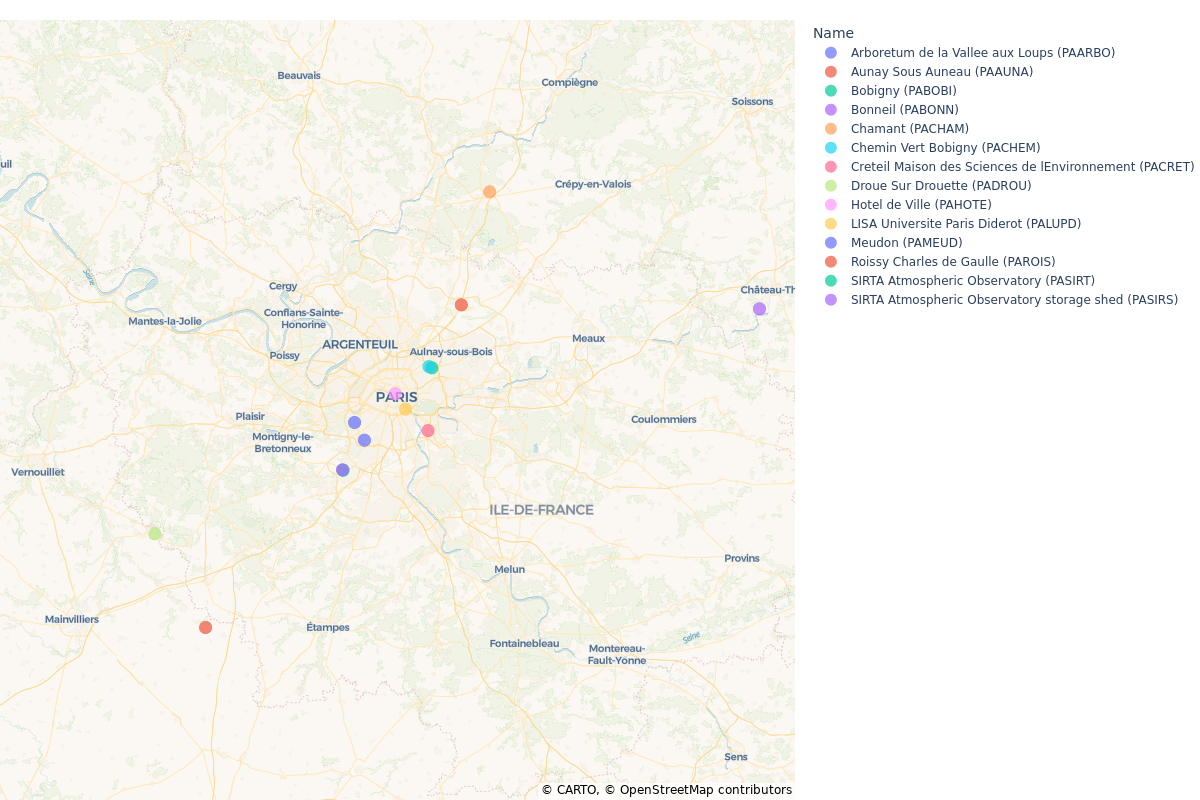

In [14]:
# basic plot
fg = px.scatter_map(
    gdf,
    lat=gdf.geometry.y,
    lon=gdf.geometry.x,
    color="Name",
    # text=list(gdf.Name) # text labels are only allowed with an apitoken for mapbox.
    hover_name=gdf.description,
    size=gdf.geometry.y * 0 + 10,
    color_continuous_scale=px.colors.sequential.Rainbow,
    size_max=10,
).update_layout(
    mapbox={
        "style": "carto-positron",
        "zoom": 8,
    },
    **{
        "height": 800,
        "width": 1200,
        "margin": dict(t=20, b=0, l=0, r=0),
    }
)

fg.show(
    renderer="png"
)  # without any labels, such a map is difficult to read, only the interactive version is reliable.
#fg.show()

## Task 3: Export feather file

### Configuration

In [15]:
feather_file = f"../tmp/metadb-export_{query_city}_{query_desc_str}.feather"

### Routine

In [16]:
# pandas has more advanced index options than arrow/feather. We need to simplify the (multi-level) indices.
metadb_export = metadb.copy()

metadb_export.columns = [".".join(a) for a in metadb.columns.to_flat_index()]

In [17]:
display(metadb_export.head(3))

,id.station_id,id.station_lat,id.station_lon,id.station_height,id.station_name,id.system_id,id.system_name,id.sensor_id,id.sensor_name,station.s_id,...,configuration.c_offset_north,configuration.c_offset_east,configuration.s_id,configuration.c_primary_c_id,configuration.c_target_facet,configuration.c_target_material,configuration.c_room_type,configuration.c_building_storey,configuration.c_distance_to_window,configuration.c_comments
101,PAHOTE,48.855890,2.352010,28.0,Hotel de Ville,50f4,4,T3250605,CL61,212,...,0,0,212,NaN,,,,None,None,
111,PAAUNA,48.431460,1.831369,156.0,Aunay Sous Auneau,100000007a936f51,4,T2920393,CL61,214,...,,,214,NaN,,,,None,None,
112,PADROU,48.601848,1.692450,149.0,Droue Sur Drouette,1000000081ea1c68,4,F2730001,CL31,215,...,,,215,NaN,,,,None,None,


In [18]:
# write output feather
metadb_export.reset_index().to_feather(feather_file)

# file name
print(f"output file: '{feather_file}'")

output file: '../tmp/metadb-export_PA_Ceilometer-DopplerLidar.feather'


In [19]:
# round trip from freather
metadb_import = pd.read_feather(feather_file)

# reset the indices.
metadb_import = metadb_import.set_index('index').rename_axis("")
metadb_import.columns= metadb_import.columns.str.split(".",expand=True)

In [20]:
display(metadb_import.head(3))

id                                                             \
    station_id station_lat station_lon station_height        station_name   
                                                                            
101     PAHOTE   48.855890    2.352010           28.0      Hotel de Ville   
111     PAAUNA   48.431460    1.831369          156.0   Aunay Sous Auneau   
112     PADROU   48.601848    1.692450          149.0  Droue Sur Drouette   

                                                        station  ...  \
            system_id system_name sensor_id sensor_name    s_id  ...   
                                                                 ...   
101              50f4           4  T3250605        CL61     212  ...   
111  100000007a936f51           4  T2920393        CL61     214  ...   
112  1000000081ea1c68           4  F2730001        CL31     215  ...   

     configuration                                                   \
    c_offset_north c_offset_east s_id c_primary_c_id c_target_facet   
                                                                      
101              0             0  212            NaN                  
111                               214            NaN                  
112                               215            NaN                  

                                                                          \
    c_target_material c_room_type c_building_storey c_distance_to_window   
                                                                           
101                                            None                 None   
111                                            None                 None   
112                                            None                 None   

                
    c_comments  
                
101             
111             
112             

[3 rows x 98 columns]